In [0]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization, GRU, Masking
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
# from numpy import argmax
# from pickle import load
# from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
# # from nltk.translate.bleu_score import corpus_bleu
import json
# import random
import csv

from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint

#Wesam
# SEED = 10
IMAGE_EMBEDDING_DIR = '/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/'
#IMAGE_EMBEDDING_VAL_DIR = '/content/drive/My Drive/Colab_Notebooks/DL_data/validation/'
# IMAGE_EMBEDDING_DIR = '/content/drive/My Drive/Colab_Notebooks/DL_data/one_sample_cnn/'
GLOVE_EMBEDDING_FILE_NAME = '/content/drive/My Drive/Colab_Notebooks/DL_data/glove.6B.300d.txt'
CAPTION_FILE_NAME = '/content/drive/My Drive/Colab_Notebooks/DL_data/image_to_caption.csv'
# filepath = '/content/drive/My Drive/Colab_Notebooks/DL_data/model-ep{epoch:03d}-loss{loss:.3f}.h5'
ALL_CAPTIONS_FILE = '/content/drive/My Drive/Colab_Notebooks/DL_data/all_captions.txt'
COMPLETE_STORIES_FILE = '/content/drive/My Drive/Colab_Notebooks/DL_data/complete_stories_all_splits.json'
IMAGE_EMBEDDING_DIM = 2048

#Vinuta
SEED = 10
#IMAGE_EMBEDDING_DIR = '/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/'
NUM_IMAGE_EMBEDDING_CHUNKS = 10
#GLOVE_EMBEDDING_FILE_NAME = 'glove.6B.300d.txt'
MAX_SEQUENCE_LENGTH = 94
WORD_EMBEDDING_DIM = 300
#CAPTION_FILE_NAME = '/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/image_to_caption.csv'
SENTENCE_EMBEDDING_DIM = 512

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


#PreProcess Captions / Stories

Either call this function or simply load preprocessed from a file



In [0]:
#to check if story ids are repeated or unique
# story_list = list()
# for key in list(all_captions_dict.keys()):
#   story_list += list(all_captions_dict[key].keys())
# from collections import Counter
# print(len(story_dict))
# d =  Counter(story_dict)
# res = [k for k, v in d.items() if v > 1]
# print(len(res)) ## gave zero .. so story ids are -in fact- unique


#image_embd =  getImageEmbedding(IMAGE_EMBEDDING_DIR)

def get_existing_stories(image_embeddings):
  #load all_captions file
  with open(ALL_CAPTIONS_FILE) as json_file:
    all_captions_dict = json.load(json_file)

  #Create a story dict (no album ids (already checked that story ids are unique))
  story_dict = {}
  for key in list(all_captions_dict.keys()):
    story_dict.update(all_captions_dict[key])


  # Create a Story dict where all images are available in the image_embeddings
  existing_stories = {}
  c=0
  for key in list(story_dict.keys()):
    lists = story_dict[key]
    images = [item[0] for item in lists]
    #captions = ['startseq ' + item[1] + ' endseq' for item in lists]
    captions = [item[1] for item in lists]
    if all(img in list(image_embeddings.keys()) for img in images):
      existing_stories[key] = [images,captions]
      c+=1
      
  print("Number of Stories Found: ")
  print(c)

  # Saving the complete existing story dict in a file
  with open(COMPLETE_STORIES_FILE, 'w') as fp:
      json.dump(existing_stories, fp)
  return existing_stories

#Vocab

In [0]:
 def vocab_fun(existing_stories_dict):
  index_to_word = {}
  word_to_index = {}
  max_seq_len=0
  all_words = {}
  all_words['startseq'] = 1
  all_words['endseq'] = 1
  cap_list = list()
  for story_id, lists in existing_stories_dict.items():
    for cap in lists[1]:
      if(len(cap.split())>max_seq_len):
        max_seq_len = len(cap.split())
      for word in cap.split():
        all_words[word] = 1
  all_vocab=[w for w in all_words]
  index = 0
  for word in all_vocab:
      word_to_index[word] = index
      index_to_word[index] = word
      index += 1
  MAX_SEQUENCE_LENGTH = max_seq_len + 2
  return (all_vocab, word_to_index, index_to_word)

#Preprocess images

In [0]:
def Merge(dict1, dict2): 
    res = {**dict1, **dict2} 
    return res 

def getImageEmbedding(path):
    image_embedding = {}
    for i in range(NUM_IMAGE_EMBEDDING_CHUNKS):
         file_name = path + 'cnn_group'+str(i+1)+'.json'
         with open(file_name) as json_file:
#    with open(file_name) as json_file:
            print(file_name)
            json_data = json.load(json_file)
            json_data = json.loads(json_data)
            image_embedding = Merge(image_embedding, json_data) 
            #image_embedding = json_data 
    return image_embedding

#Load Stories (captions with corresponding Image ids)
##Dict items as follows (per story)
[ [img_id1, img_id2, img_id3, img_id4, img_id5] , [cap1, cap2, cap3, cap4, cap5] ]

Each captions starts with **startseq** and ends with **endseq**

In [0]:
def get_existing_stories_from_file():
  with open(COMPLETE_STORIES_FILE, 'r') as fp:
      existing_stories = json.load(fp)
  return existing_stories

#Use Prev to get captions / stories and images and pre_process them

In [0]:
#for training
image_embd =  getImageEmbedding(IMAGE_EMBEDDING_DIR)
print(len(image_embd))


/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group1.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group2.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group3.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group4.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group5.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group6.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group7.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group8.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group9.json
/content/drive/My Drive/Colab_Notebooks/DL_data/CNNFeatureVectors/cnn_group10.json
58197


In [0]:
#get existing_stories (either load from file or using a function , preferably load from file) -- uncomment one of the following 2 lines
existing_stories = get_existing_stories_from_file()
#existing_stories = get_existing_stories(image_embd) #Number of Stories Found: 35565

all_vocab, wordtoix, ixtoword=vocab_fun(existing_stories)
print('Max Seq Len: %d' %MAX_SEQUENCE_LENGTH)
vocab_size = len(all_vocab)
print('Vocabulary Size: %d' % vocab_size)

Max Seq Len: 94
Vocabulary Size: 26571


In [0]:
print(existing_stories['2905'])

[['4562798695', '4563429868', '4562801065', '4563434166', '4563436748'], ['my trip to location was amazing .', 'i saw some colorful people .', 'i even made some knew friends .', 'i visited a beautiful pagoda .', 'then i saw a ordinary bicycle .']]


#Embedding Matrix

In [0]:
#get matrix embedding for glove
embeddings_index = {} # empty dictionary
f = open(GLOVE_EMBEDDING_FILE_NAME, encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))


# Get 300-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, WORD_EMBEDDING_DIM))
for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


#IMAGE EMBEDDINGS

In [0]:
def get_image_indices(image_embd):
  index = 0
  img_to_index = {}
  index_to_img = {}
  for img_id in image_embd:
      img_to_index[img_id] = index
      index_to_img[index] = img_id
      index += 1
  return img_to_index, index_to_img

In [0]:
#creat image to index and index to image
imgtoix, ixtoimg = get_image_indices(image_embd)

img_embedding_matrix = np.zeros((len(image_embd), IMAGE_EMBEDDING_DIM))
for img, ix in imgtoix.items():
    #if i < max_words:
    embedding_vector = image_embd.get(img)
    if embedding_vector is not None:
        img_embedding_matrix[ix] = embedding_vector

#Input and output for the model
###X1, X2, X3, y

In [0]:

import tensorflow as tf
import tensorflow_hub as hub
def all_data(stories_dict, image_embd, wordtoix, max_length, num_of_stories):
  X1, X2, X3, y = list(), list(), list(), list()
  # sentence_encoder = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/2") #512
  #to generate X1,X2,X3 and y. ////append-> have a list of image embeds , have a list for curr caption, have sentences embed for previous sentences, next word
  #for each story:
  for key, lists in stories_dict.items():
    #break after retreiving num_of_stories
    if num_of_stories <= 0:
      break
    num_of_stories -= 1
    #if all image_ids exists in image_embd: --- done-- no need to check since checking is done during preprocessing
    img_list=lists[0]
    img_list_embed=[imgtoix[img_id] for img_id in img_list]#[image_embd[img_id] for img_id in img_list]
    prev_list=lists[1].copy()
    prev_list.pop()
    # with tf.Session() as session:
    #   session.run([tf.global_variables_initializer(), tf.tables_initializer()])
    #   all_sen_embeddings = session.run(sentence_encoder(prev_list))
    # all_sen_embeddings.tolist().insert(0,[0]*SENTECE_EMBEDDING_DIM) #for first sentence (empty vector)
    prev_list.insert(0,'')

    for counter in range(5):
      img_seq = img_list_embed[:counter+1]
      img_seq = pad_sequences([img_seq], maxlen=5)[0]
      prev_sents = ' '.join(prev_list[:counter+1])
      prev_embeddings = [wordtoix[word] for word in prev_sents.split() if word in wordtoix]
      prev_embeddings = pad_sequences([prev_embeddings], maxlen=max_length*4)[0]
      cap=lists[1][counter]
      cap_in = 'startseq ' + cap
      cap_out = cap + ' endseq'
      seq_in = [wordtoix[word] for word in cap_in.split() if word in wordtoix]
      seq_in = pad_sequences([seq_in], maxlen=max_length, padding='post')[0]
      seq_out = [wordtoix[word] for word in cap_out.split() if word in wordtoix]
      seq_out = pad_sequences([seq_out], maxlen=max_length, padding='post')[0]
      #seq_out = to_categorical([seq_out], num_classes=vocab_size)[0]
      
      X1.append(img_seq)
      X2.append(seq_in)
      X3.append(prev_embeddings)
      y.append(seq_out)

  return (array(X1), array(X2), array(X3), array(y))




In [0]:
# X1,X2,X3,y = all_data(existing_stories, image_embd, wordtoix, MAX_SEQUENCE_LENGTH, 35565)


In [0]:
# print(np.shape(X2))
# print(np.shape(y))

(177825, 94)
(177825, 94)


#Building Model

In [0]:
# Things I should try:
# 1- bidirectional
# 2- return sequences and merge the two layers
# 3- must get good results on validation (the model must be generalizable)
# 4- modify hyper parameters (hidden layers, batch size, learning rate) (with larger batch size we can use larger learning rate)

# from keras.regularizers import l2, l1

# def build_model():
#   inputs1 = Input(shape=(5,),name='images')
#   img1 = Embedding(len(image_embd), IMAGE_EMBEDDING_DIM , mask_zero=True, weights=[img_embedding_matrix], trainable=False)(inputs1)
#   img2 = Dropout(0.5)(img1)
#   img3 = GRU(256, recurrent_dropout=0.3, activity_regularizer=l2(0.001))(img2)

#   inputs2 = Input(shape=(MAX_SEQUENCE_LENGTH,),name='sequences')
#   seq1 = Embedding(vocab_size, WORD_EMBEDDING_DIM, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs2)
#   seq2 = Dropout(0.5)(seq1)
#   seq3 = GRU(256,recurrent_dropout=0.3, activity_regularizer=l2(0.001))(seq2)
  
#   inputs3 = Input(shape=(MAX_SEQUENCE_LENGTH*4,),name='prev_sentences')
#   sen1 = Embedding(vocab_size, WORD_EMBEDDING_DIM, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs3)
#   seq2 = Dropout(0.5)(seq1)
#   sen2 = GRU(256,recurrent_dropout=0.3, activity_regularizer=l2(0.001))(sen1)


#   decoder1 = add([img3, seq3, sen2])
#   decoder2 = Dense(256, activation=None, kernel_regularizer=l2(0.001))(decoder1)
#   outputs = Dense(vocab_size, activation='softmax')(decoder2)
#   model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)
#   return model



from keras.regularizers import l2, l1

def sparse_cross_entropy(y_true, y_pred):
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred)
    loss_mean = tf.reduce_mean(loss)
    return loss_mean


def build_model():
  inputs1 = Input(shape=(5,),name='images')
  img1 = Embedding(len(image_embd), IMAGE_EMBEDDING_DIM , mask_zero=True, weights=[img_embedding_matrix], trainable=False)(inputs1)
  img2 = Dropout(0.5)(img1)
  img3, img_hidden = GRU(300, recurrent_dropout=0, return_state=True , activity_regularizer=l2(0.001))(img2)


#Concatenate()([forward_h, backward_h])
  inputs3 = Input(shape=(MAX_SEQUENCE_LENGTH*4,),name='prev_sentences')
  sen1 = Embedding(vocab_size, WORD_EMBEDDING_DIM, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs3)
  sen2 = Dropout(0.5)(sen1)
  #sen3, sen_hidden_f, sen_hidden_b = Bidirectional(GRU(300,recurrent_dropout=0, return_state=True, activity_regularizer=l2(0.001)), merge_mode='sum')(sen2)
  sen_hidden= Bidirectional(GRU(300,recurrent_dropout=0, activity_regularizer=l2(0.001)), merge_mode='sum')(sen2)
  #sen_hidden =  add([sen_hidden_f,sen_hidden_b])
  decoder_hidden = add([img_hidden,sen_hidden])
#img_hidden

  inputs2 = Input(shape=(MAX_SEQUENCE_LENGTH,),name='sequences')
  seq1 = Embedding(vocab_size, WORD_EMBEDDING_DIM, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs2)
  seq2 = Dropout(0.5)(seq1)
  decoder1 = GRU(300,recurrent_dropout=0, return_sequences=True ,activity_regularizer=l2(0.001))(seq2, initial_state=decoder_hidden)
  
  



#initial_state

  #decoder1 = add([img3, seq3, sen2]) #maybe use Add()()?
  decoder2 = Dense(300, activation=None, kernel_regularizer=l2(0.001))(decoder1)
  outputs = Dense(vocab_size, activation='linear')(decoder2) ##was softmax /// used linear because it's recommended with the custom loss: https://github.com/tensorflow/tensorflow/issues/17150
  model = Model(inputs=[inputs1, inputs2, inputs3], outputs=outputs)

  model.summary()
  #opt = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
  #opt = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
  #opt = Adams(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
  #opt = Adam(lr=0.1, decay=0.1)
  #opt = RMSprop(lr=0.001, rho=0.9)
  decoder_target = tf.placeholder(dtype='int32', shape=(None, None))
  model.compile(loss=sparse_cross_entropy, optimizer='adam', target_tensors=[decoder_target])#'adam')


  return model

#Training

In [0]:
model=build_model()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
images (InputLayer)             (None, 5)            0                                            
__________________________________________________________________________________________________
prev_sentences (InputLayer)     (None, 376)          0                                            
__________________________________________________________________________________________________
embedding_49 (Embedding)        (None, 5, 2048)      119187456   images[0][0]                     
__________________________________________________________________________________________________
embedding_50 (Embedding)        (None, 376, 300)     7971300     prev_sentences[0][0]             
___________________________________________________________________________________________

#Or load saved model

In [0]:
#model = load_model('/content/drive/My Drive/Colab_Notebooks/DL_data/models/final_model_basic_100_stories_checkpoint-ep033-loss3.835.h5')

In [0]:
X1,X2,X3,y = all_data(existing_stories, image_embd, wordtoix, MAX_SEQUENCE_LENGTH, 35565)#35565
filepath_checkpoint = "/content/drive/My Drive/Colab_Notebooks/DL_data/models/final_model_basic_100_stories-ep{epoch:03d}-loss{loss:.3f}.h5"
#checkpoint = ModelCheckpoint(filepath_checkpoint, monitor='val_loss', verbose=1, save_best_only=False, mode='min')
history = model.fit([X1,X2,X3], y, epochs=200, verbose=1, batch_size=32, validation_split=0.1, shuffle=True, workers=10, use_multiprocessing=True) #callbacks=[checkpoint]
model.save('/content/drive/My Drive/Colab_Notebooks/DL_data/models/final_model_basic_100_stories_finale.h5')

Train on 160042 samples, validate on 17783 samples
Epoch 1/200
140608/160042 [=========================>....] - ETA: 17:00 - loss: 1.4849

#Plot loss curve

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


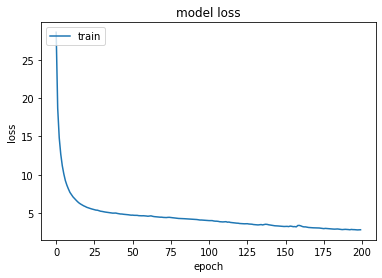

In [0]:
import matplotlib.pyplot as plt
print(history.history.keys())
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

#Preprocessing Needed for prediction

In [0]:
import os.path as osp
import os
from pprint import pprint
from skimage.transform import rescale, resize
from skimage import data, color, io
import skimage
import PIL
import scipy
import json
import os.path
from os import path
import tensorflow as tf

from keras.applications.xception import preprocess_input
from keras.applications.xception import Xception
from keras.models import Model
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img
from keras.applications.imagenet_utils import decode_predictions
def word_for_id(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None
def load_image(image_path,target_size):
    img = skimage.io.imread(image_path)
    image_resized = skimage.transform.resize(img, target_size, anti_aliasing=True)
    return image_resized

def load_cnn_model():
    model = Xception()
    model.layers.pop()
    model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
    return model

def extract_features_from_images(image_path):
    model = load_cnn_model()
    if path.exists(image_path):
        print(image_path)
        image = load_image(image_path, target_size=(299, 299))
        if image.shape == (299, 299, 3):
            image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
            image = preprocess_input(image)
            feature = model.predict(image, verbose=0)
            print(feature)
            return feature

def generate_desc(model, photo, max_length):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[word] for word in in_text.split() if word in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        # map integer to word
        word = ixtoword[yhat]
        if word is None:
            break
        in_text += ' ' + word
        if word == 'endseq':
            break
    return in_text

#Prediction

In [0]:
image_path='/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/124919.jpg'#'/Users/vinutahegde/Documents/Personal/IMG_3501.JPG'
feature=extract_features_from_images(image_path)
print(generate_desc(model, feature, max_length))

In [0]:
image_path='/Users/vinutahegde/Documents/USC/SEM3/DL/project/ws/images/train/images/train/124871.jpg'
feature=extract_features_from_images(image_path)
print(generate_desc(model, feature, max_length))